In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Embedding, Dense, GlobalAveragePooling1D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2



AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

In [ ]:
# Load the IMDB dataset with reduced vocabulary size
(X_train_full, y_train_full), (X_test_full, y_test_full) = imdb.load_data(num_words=3000)



In [ ]:
# Combine train and test sets for custom splitting
X_full = np.concatenate((X_train_full, X_test_full), axis=0)
y_full = np.concatenate((y_train_full, y_test_full), axis=0)



In [ ]:
# Decode the reviews back to text
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

# Decode all reviews
X_full_text = [decode_review(review) for review in X_full]



In [ ]:
# Create a DataFrame
data = pd.DataFrame({'text': X_full_text, 'label': y_full})



In [ ]:
# Split data into train (60%), validation (20%), and test (20%)
# First, split into train+val (80%) and test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    data['text'].values, data['label'].values, test_size=0.2, random_state=42, stratify=data['label']
)

# Then, split train+val into train (75% of 80% = 60%) and val (25% of 80% = 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)



In [ ]:
# Print split sizes
print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')



Training set size: 30000
Validation set size: 10000
Test set size: 10000


In [ ]:
# Tokenize the text with reduced vocabulary size
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train)



In [ ]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)



In [ ]:
# Pad sequences
max_length = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')



In [ ]:
# Build the GRU model with dropout, L2 regularization, and batch normalization
model = Sequential()
model.add(Embedding(input_dim=3000, output_dim=128))
model.add(GRU(16, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling1D())
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))



In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)



In [ ]:
# Train the model with early stopping and learning rate scheduling
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64,
                    validation_data=(X_val_pad, y_val), callbacks=[early_stopping, lr_scheduler])



Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2032s 4s/step - accuracy: 0.6483 - loss: 0.9365 - val_accuracy: 0.7382 - val_loss: 0.5694 - learning_rate: 0.0010
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1991s 4s/step - accuracy: 0.8295 - loss: 0.4537 - val_accuracy: 0.8712 - val_loss: 0.3378 - learning_rate: 0.0010
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1927s 4s/step - accuracy: 0.8715 - loss: 0.3544 - val_accuracy: 0.8840 - val_loss: 0.3091 - learning_rate: 0.0010
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1929s 4s/step - accuracy: 0.8787 - loss: 0.3222 - val_accuracy: 0.8524 - val_loss: 0.3806 - learning_rate: 0.0010
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1901s 4s/step - accuracy: 0.8897 - loss: 0.3094 - val_accuracy: 0.8722 - val_loss: 0.3644 - learning_rate: 0.0010


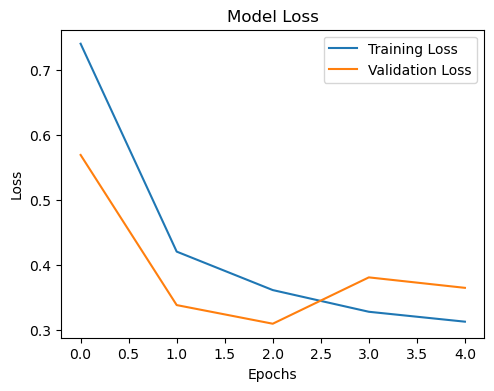

In [ ]:
# Plot model loss and accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



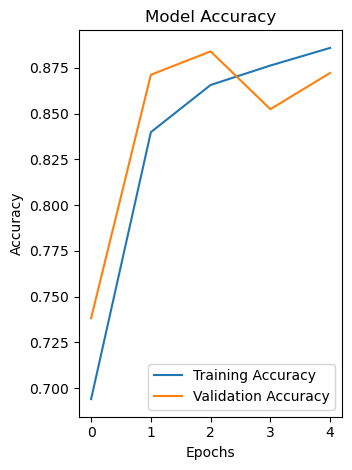

In [ ]:
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



313/313 ━━━━━━━━━━━━━━━━━━━━ 200s 639ms/step


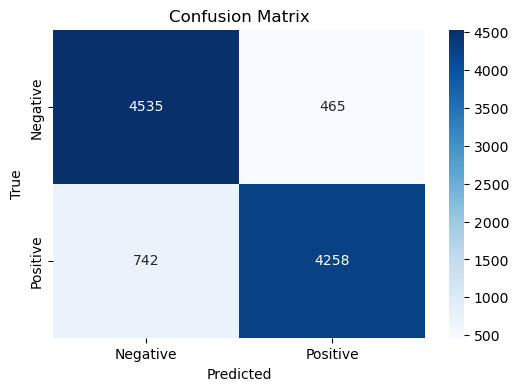

In [ ]:
# Confusion matrix on test set
y_pred = (model.predict(X_test_pad) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [ ]:
# Evaluate the model on test set
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.2f}')



313/313 ━━━━━━━━━━━━━━━━━━━━ 200s 638ms/step - accuracy: 0.8729 - loss: 0.3202
Test Accuracy: 0.88


In [ ]:
# Example predictions
sample_texts = ["this product is great!", "This product is terrible."]
sample_seq = tokenizer.texts_to_sequences(sample_texts)
sample_pad = pad_sequences(sample_seq, maxlen=max_length, padding='post')
predictions = model.predict(sample_pad)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


In [ ]:
# Show predictions
for text, pred in zip(sample_texts, predictions):
    sentiment = 'Positive' if pred > 0.5 else 'Negative'
    print(f'Text: {text} - Sentiment: {sentiment}')

Text: this product is great! - Sentiment: Positive
Text: This product is terrible. - Sentiment: Negative
